## User Behaviour on Twitter
Unsupervised clustering and interpreting.

In [21]:
!pip3 install pandas seaborn tqdm
!pip3 install scikit-learn

You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/5c/a1/273def87037a7fb010512bbc5901c31cfddfca8080bc63b42b26e3cc55b3/scikit_learn-0.23.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/fc/c9/f58220ac44a1592f79a343caba12f6837f9e0c04c196176a3d66338e1ea8/joblib-0.17.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/12/ec3f2e203afa394a149911729357aa48affc59c20e2c1c8297a60f33f133/threadpoolctl-2.1.0-py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
#import libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import  tqdm #NOT NEEDED, JUST USED WHEN WRITING THE NOTEBOOK

In [10]:
#loading
egoalter = pd.read_csv('./EgoAlterProfiles.txt',delimiter='\t')
#egonet = pd.read_csv('./EgoNetworks.txt',delimiter='\t')
egotimes = pd.read_csv('./EgoTimelines.txt',delimiter='\t',encoding='latin-1')

In [11]:
# Apply the default theme
sns.set_theme()

In [12]:
egoalter

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False
3,4,True,3.0,3,68.0,NaN,en,Sun Feb 14 07:50:39 +0000 2010,False
4,5,True,65.0,118,748.0,NaN,fr,Mon Jun 11 14:17:06 +0000 2012,False
...,...,...,...,...,...,...,...,...,...
2516185,2516186,False,5129.0,191,403.0,10800.0,ar,Mon Jun 23 22:56:28 +0000 2014,False
2516186,2516187,False,6694.0,11,1523.0,-14400.0,en,Wed Jul 08 09:10:18 +0000 2009,False
2516187,2516188,False,6651.0,216,7141.0,-18000.0,en,Thu Jun 16 00:06:46 +0000 2011,False
2516188,2516189,False,21.0,59,33.0,NaN,en,Fri Nov 30 05:31:27 +0000 2012,False


In [24]:
egotimes

,replyto_userid,retweeted_userid,id,tweetid,created_at,hashtags,urls,mentions_ids,retweet_count,egoID,retweetedUserID,replytoUserID,metionID
0,NaN,NaN,398477318,249552537051598848,Sat Sep 22 16:55:35 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN
1,NaN,NaN,398477318,249537963145433088,Sat Sep 22 15:57:41 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN
2,NaN,NaN,398477318,129377372209299456,Thu Oct 27 02:02:23 +0000 2011,NaN,NaN,NaN,0,1,NaN,NaN,NaN
3,NaN,NaN,398477318,302401054690140160,Fri Feb 15 12:56:44 +0000 2013,NaN,NaN,797583722,0,1,NaN,NaN,1970142
4,NaN,NaN,398477318,249538739611787264,Sat Sep 22 16:00:46 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4702253,NaN,1.908175e+09,2450373612,457512764609527808,Sat Apr 19 13:35:17 +0000 2014,NaN,NaN,1908174541,116,34003,1665499.0,NaN,1665499
4702254,NaN,1.908175e+09,2450373612,457500823937761280,Sat Apr 19 12:47:51 +0000 2014,NaN,NaN,1908174541,130,34003,1665499.0,NaN,1665499
4702255,NaN,2.741554e+07,2450373612,457581679150780416,Sat Apr 19 18:09:08 +0000 2014,NaN,NaN,27415537,465,34003,2212205.0,NaN,2212205
4702256,1.086140e+09,NaN,2450373612,457174276064284673,Fri Apr 18 15:10:15 +0000 2014,NaN,NaN,"1086139884,1086139884",0,34003,NaN,992318.0,"992318,992318"


In [35]:
set(egotimes['urls'].fillna(value=-1))

{'http://t.co/vr9nyAQ5HO',
 'http://t.co/KL1NfN4krf',
 'http://t.co/SSXL8h8t',
 'http://t.co/clLDer3gb5',
 'http://t.co/RnAicI3Att',
 'http://t.co/HzqPu2CLqj',
 'http://t.co/9GkupMqTJP',
 'http://t.co/NyfuuwquXa',
 'http://t.co/uArwmtHr',
 'http://t.co/BflpmGxW',
 'http://t.co/RQ1QL8ObsR',
 'http://t.co/3OO1vqyzU1',
 'https://t.co/wSkHrWAVS2',
 'http://t.co/RYXKWsw1d5',
 'http://t.co/4elot4P9Fi',
 'http://t.co/HKKg1bd8T1',
 'http://t.co/xDusxhXdLS',
 'http://t.co/2xHaxd5cTp',
 'https://t.co/0VTTwNdJYR',
 'http://t.co/Yah3iJs',
 'http://t.co/MVaHhp4DTB',
 'http://t.co/RIgCp59PzT',
 'http://t.co/hchQXlPKRf',
 'http://t.co/DcPftMop',
 'http://t.co/UctoiyqI',
 'http://t.co/HqZUPKIisu',
 'http://t.co/EBJcMJDE',
 'https://t.co/sAM3AKSkbY',
 'http://t.co/cIOpWnGcCa',
 'http://t.co/ShPAaJbFUE,http://t.co/ShPAaJbFUE',
 'http://t.co/6Mh6XNV7',
 'http://t.co/oWfx82iu9r',
 'http://t.co/2Xp6GmiO',
 'http://t.co/pt3qHDp2',
 'http://t.co/0nU4B7v7IB',
 'https://t.co/zXFbhPpWG5',
 'http://t.co/684AtQ3b

In [34]:
set(egotimes['hashtags'].fillna(value=-1))

{'documentmanagement',
 '<U+0628><U+0637><U+0648><U+0644><U+0629>_<U+0627><U+0644><U+0639><U+064A><U+0646>_<U+0627><U+0644><U+062F><U+0648><U+0644><U+064A><U+0647>',
 'RT<U+3057><U+305F><U+4EBA><U+5168><U+54E1><U+30D5><U+30A9><U+30ED><U+30FC><U+3059><U+308B>,nr<U+3055><U+3093>bot<U+3055><U+3093><U+306E><U+304A><U+53CB><U+9054><U+5897><U+3084><U+3057><U+305F><U+3044>',
 '<U+0625><U+064A><U+0631><U+0627><U+0646>,<U+0627><U+0644><U+0643><U+0639><U+0628><U+0629>_<U+0627><U+0644><U+0645><U+0634><U+0631><U+0641><U+0629>,<U+0627><U+0644><U+0633><U+0639><U+0648><U+062F><U+064A><U+0629>',
 'MerchantServices,MerchantAccount,SmallBiz,SMB',
 'LAKings,welldeserved,StanleyCup',
 'FintasyDribles,LosManriquez',
 'LaborDayWeekend,TurntUpSundays,SaharaBar',
 'cirujano',
 'indyref,teasout',
 '<U+521D><U+898B><U+3055><U+3093><U+5927><U+6B53><U+8FCE>',
 'mostinterestingman,shortgrass',
 'Deep,Wrexxshop,SohoGastro,Hype',
 'GeziciCAPULyalanlari',
 '<U+0627><U+0644><U+0644><U+0647>_<U+064A><U+0631><U+062D><U+

In [36]:
def extract_info(df):
    
    n = len(df)
    interact1 = n - np.sum(df['replyto_userid'].isnull())
    interact2 = n - np.sum(df['mentions_ids'].isnull())
    
    popular1 = np.nansum(df['retweet_count'])
    
    hashtag = n - np.sum(df['hashtags'].isnull())
    urls = n - np.sum(df['urls'].isnull())
    
    
    return [interact1, interact2, popular1, n, hashtag, urls]

In [82]:
isEgo = egoalter.loc[egoalter['IsEgo']]

In [83]:
isEgo

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False
3,4,True,3.0,3,68.0,NaN,en,Sun Feb 14 07:50:39 +0000 2010,False
4,5,True,65.0,118,748.0,NaN,fr,Mon Jun 11 14:17:06 +0000 2012,False
...,...,...,...,...,...,...,...,...,...
34001,34002,True,0.0,0,0.0,NaN,ar,Sun Feb 16 20:12:58 +0000 2014,False
34002,34003,True,194.0,95,370.0,NaN,es,Thu Apr 17 20:22:32 +0000 2014,False
34003,34004,True,0.0,0,0.0,NaN,id,Sun Sep 01 11:39:26 +0000 2013,False
34004,34005,True,1.0,19,0.0,NaN,pt,Sun Jan 12 01:24:51 +0000 2014,False


In [85]:
interact1s, interact2s = [], []
popular1 = []
activity = []
hashtags = []
urls = []
ids = []


ego_intersect = set(egotimes['egoID'].unique()).intersection(set(isEgo['ID']))
for _id in tqdm(ego_intersect):
    int1, int2, pop1, n, hashtag, url = extract_info(egotimes.loc[egotimes['egoID']==_id])
    interact1s.append(int1) ; interact2s.append(int2)
    popular1.append(pop1)
    activity.append(n)
    hashtags.append(hashtag)
    urls.append(url)
    ids.append(_id)

100%|██████████| 17244/17244 [01:33<00:00, 185.41it/s]


In [87]:
df = pd.DataFrame(list(zip(interact1s, interact2s, popular1, activity, hashtags, urls,ids)), 
               columns =['interact1', 'interact2', 'popular1', 'activity','hashtags' , 'urls', 'ID']) 

In [88]:
df

,interact1,interact2,popular1,activity,hashtags,urls,ID
0,4,44,23633,143,22,3,32768
1,4,8,0,9,0,0,1
2,2,2,0,7,1,3,2
3,24,44,70628,53,1,1,32769
4,0,0,0,68,0,59,4
...,...,...,...,...,...,...,...
17239,0,0,0,1,0,0,32757
17240,4,46,19822,76,0,0,32758
17241,1,1,0,2,0,0,32759
17242,0,0,0,3,0,0,32761


In [22]:
from sklearn.cluster import KMeans

[[  12.26616018   25.38917379]
 [ 459.69550173 2083.52595156]
 [1465.08053691 1889.29865772]
 [ 428.60324826  859.11020882]]


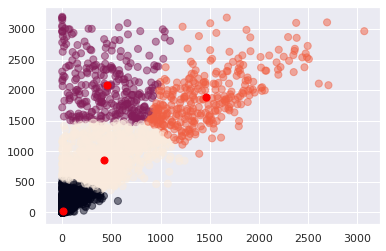

In [50]:
kmeans = KMeans(n_clusters=4).fit(df.iloc[:,:2])
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df['interact1'], df['interact2'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [89]:
clustered = df.copy()
clustered['cluster'] = kmeans.labels_

In [91]:
cluster_alter = pd.merge(clustered,isEgo.loc[isEgo['ID'].isin(ego_intersect)],on='ID')

In [93]:
cluster_alter

,interact1,interact2,popular1,activity,hashtags,urls,ID,cluster,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
0,4,44,23633,143,22,3,32768,0,True,46.0,212,143.0,NaN,pt,Fri Apr 04 00:16:53 +0000 2014,False
1,4,8,0,9,0,0,1,0,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False
2,2,2,0,7,1,3,2,0,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
3,24,44,70628,53,1,1,32769,0,True,42.0,105,53.0,NaN,en,Mon Oct 13 22:16:22 +0000 2014,False
4,0,0,0,68,0,59,4,0,True,3.0,3,68.0,NaN,en,Sun Feb 14 07:50:39 +0000 2010,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17239,0,0,0,1,0,0,32757,0,True,0.0,1,1.0,NaN,en,Sun Jul 28 05:00:40 +0000 2013,False
17240,4,46,19822,76,0,0,32758,0,True,37.0,72,79.0,NaN,en,Sat Aug 31 18:41:51 +0000 2013,False
17241,1,1,0,2,0,0,32759,0,True,1.0,45,2.0,NaN,en,Fri Dec 06 02:23:10 +0000 2013,False
17242,0,0,0,3,0,0,32761,0,True,0.0,1,3.0,NaN,pt,Sat Sep 20 02:15:14 +0000 2014,False


In [102]:
def plot_prop(nb_cluster,prop):
    d = dict()
    for i in range(nb_cluster):
        d[i] = cluster_alter.loc[cluster_alter['cluster']==i][prop]
    distributions = pd.DataFrame(data=d)
    fig = distributions.plot.kde()
    fig.set_xscale('log')

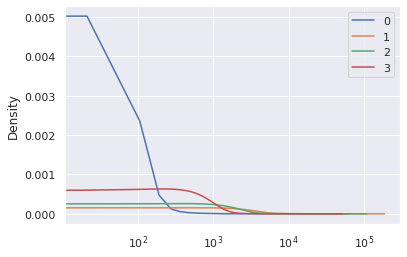

In [103]:
plot_prop(4,'followers_count')

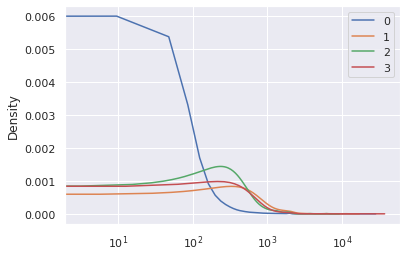

In [104]:
plot_prop(4,'friends_count')

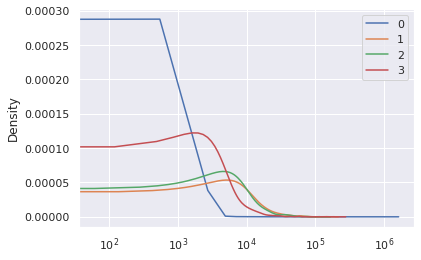

In [105]:
plot_prop(4,'statuses_count')

[[4.31407095e+04 2.50056518e+02]
 [2.25848488e+07 2.46477273e+03]
 [4.80615259e+06 1.93572959e+03]
 [7.34576974e+07 2.48360000e+03]]


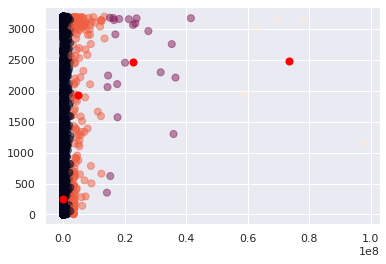

In [43]:
kmeans = KMeans(n_clusters=4).fit(df.iloc[:,2:4])
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df['popular1'], df['activity'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()